In [1]:
import time
from datetime import timedelta

import torch as tt
from torch.utils.data import DataLoader
from epnl import model, tasks, embedding, data

import pandas as pd

import matplotlib.pyplot as plt

import os.path as op

In [5]:
def setup_test(task, classes, file, embedder):
    embedder = embedding.embedder_from_str(embedder)
    
    task = tasks.EdgeProbingTask(task, classes, embedder=embedder)

    infer_model = model.EdgeProbingModel(task, embedder)
    infer_model.load_state_dict(tt.load(op.join("epnl/output/", file)))
    infer_model.eval()
    
    data_test = task.get_data(tasks.Task.TEST)
    loader_test = DataLoader(data_test, batch_size=32, shuffle=False, num_workers=4)

    start_time = time.time()

    rates = {"tp": 0, "tn": 0, "fp": 0, "fn": 0}

    print(f"Validating task {task.get_name()}")

    with tt.no_grad():
        for i_batch, batch in enumerate(loader_test):
            outputs = infer_model(batch)

            tp, tn, fp, fn = outputs["rates"]
            rates["tp"] += tp
            rates["tn"] += tn
            rates["fp"] += fp
            rates["fn"] += fn

    metrics = {
        "f1": model.get_metric(rates, "f1"),
        "acc": model.get_metric(rates, "acc")
    }

    print(f"Test {task} with {embedder} [{timedelta(seconds=time.time() - start_time)}]")
    print(f"\t{' '.join([f'{m} {round(metrics[m], 4)}' for m in metrics])}")

## TroFi

In [6]:
setup_test(task="trofi",
           classes=1,
           file="model-trofi-08Dec19-08-24.pt", 
           embedder="BERT")

setup_test(task="trofi",
           classes=1,
           file="model-trofi-08Dec19-09-09.pt", 
           embedder="BERTL")

setup_test(task="trofi",
           classes=1,
           file="model-trofi-08Dec19-10-17.pt", 
           embedder="GPT2")

Validating task trofi
Test EdgeProbingTask <N: 1 E: BERT> with BERT [0:00:00.687485]
	f1 0.7624 acc 0.7998
Validating task trofi
Test EdgeProbingTask <N: 1 E: BERT-Large> with BERT-Large [0:00:01.023407]
	f1 0.7181 acc 0.7495
Validating task trofi
Test EdgeProbingTask <N: 1 E: GPT2> with GPT2 [0:00:00.682812]
	f1 0.6675 acc 0.7024


## DPR

In [7]:
setup_test(task="dpr",
           classes=1,
           file="model-dpr-08Dec19-08-29.pt", 
           embedder="BERT")

setup_test(task="dpr",
           classes=1,
           file="model-dpr-08Dec19-09-14.pt", 
           embedder="BERTL")

setup_test(task="dpr",
           classes=1,
           file="model-dpr-08Dec19-10-30.pt", 
           embedder="GPT2")

Validating task dpr
Test EdgeProbingTask <N: 1 E: BERT> with BERT [0:00:00.513643]
	f1 0.6519 acc 0.5142
Validating task dpr
Test EdgeProbingTask <N: 1 E: BERT-Large> with BERT-Large [0:00:00.856726]
	f1 0.613 acc 0.5401
Validating task dpr
Test EdgeProbingTask <N: 1 E: GPT2> with GPT2 [0:00:00.638237]
	f1 0.5369 acc 0.5142


## Metonymy

In [15]:
setup_test(task="metonymy",
           classes=1,
           file="model-metonymy-08Dec19-08-43.pt", 
           embedder="BERT")

setup_test(task="metonymy",
           classes=1,
           file="model-metonymy-08Dec19-10-06.pt", 
           embedder="BERTL")

setup_test(task="metonymy",
           classes=1,
           file="model-metonymy-08Dec19-12-08.pt", 
           embedder="GPT2")

Validating task metonymy
Test EdgeProbingTask <N: 1 E: BERT> with BERT [0:00:00.749660]
	f1 0.6508 acc 0.8453
Validating task metonymy
Test EdgeProbingTask <N: 1 E: BERT-Large> with BERT-Large [0:00:00.933254]
	f1 0.6008 acc 0.8544
Validating task metonymy
Test EdgeProbingTask <N: 1 E: GPT2> with GPT2 [0:00:00.756638]
	f1 0.5138 acc 0.7613


## Progress

In [9]:
progress = {"trofi": "epnl/output/history-08Dec19-10-18.json",
            "dpr": "epnl/output/history-08Dec19-10-30.json"}
#             "metonymy": "epnl/output/output-06Dec19-17-43.json"}

progress_reports = pd.DataFrame()

for s in progress:
    report = pd.read_json(progress[s])
    report["data"] = s
    
    progress_reports = pd.concat([progress_reports, report], axis=0, sort=False)

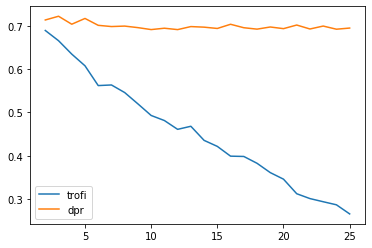

In [14]:
for s in progress:
    d = progress_reports.loc[progress_reports["data"] == s, :]
    plt.plot(d.loc[d["set"] == "train", "epoch"]+1, 
             d.loc[d["set"] == "train", "loss"],
             label = s)
    
plt.legend();